# HW2


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import imread
from skimage.transform import resize
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from glob import glob
%config InlineBackend.figure_format = 'svg'

def load_notmnist(path='./notMNIST_small',letters='ABCDEFGHIJ',
                  img_shape=(28,28),test_size=0.25,one_hot=False):
    
    # download data if it's missing. If you have any problems, go to the urls and load it manually.
    if not os.path.exists(path):
        print("Downloading data...")
        assert os.system('curl http://yaroslavvb.com/upload/notMNIST/notMNIST_small.tar.gz > notMNIST_small.tar.gz') == 0
        print("Extracting ...")
        assert os.system('tar -zxvf notMNIST_small.tar.gz > untar_notmnist.log') == 0
    
    data,labels = [],[]
    print("Parsing...")
    for img_path in glob(os.path.join(path,'*/*')):
        class_i = img_path.split(os.sep)[-2]
        if class_i not in letters: 
            continue
        try:
            data.append(resize(imread(img_path), img_shape))
            labels.append(class_i,)
        except:
            print("found broken img: %s [it's ok if <10 images are broken]" % img_path)
        
    data = np.stack(data)[:,None].astype('float32')
    data = (data - np.mean(data)) / np.std(data)

    #convert classes to ints
    letter_to_i = {l:i for i,l in enumerate(letters)}
    labels = np.array(list(map(letter_to_i.get, labels)))
    
    if one_hot:
        labels = (np.arange(np.max(labels) + 1)[None,:] == labels[:, None]).astype('float32')
    
    #split into train/test
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_size, stratify=labels)
    
    print("Done")
    return X_train, y_train, X_test, y_test

## Task description

In this notebook you are suggested to train several models of machine learning on the notMNIST dataset. To get full points per each model it must beat the **baseline** on test dataset. Models to test:

* naive Bayes classifier, 80% (**0.5 points**)
* decision tree, 83.5% (**1.5 points**)
* random forest, 91.5% (**2 points**)
* [CatBoost](https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier), 92% (**1.5 points**)
* MLP, 93% (**2.5 points**)
* CNN, 95% (**3 points**)
* overall comparison of models, including some graphs (e.g, bar plot for test accuracy) (**1 point**)

### Important notes

* All outputs of code cells must be preserved in your submission
* Broken code in a section automatically implies $0$ points for this section
* Do not erase any existing cells
* Use magic cell %%time to measure the time of execution of heavy-computation cells
* For each model use the followind structure:
    1. Import and build model

    2. Fit model on train dataset

    3. Tune one or several hyperparameter to improve the peformance of your model (you may find [randomized search](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) useful)

    3. Print train and test accuracy of your best model

    4. Make predictions of your best model on test dataset

    5. Plot confusion matrix

    6. Plot 16 random samples from the test dataset with true labels and predicted classes
* Keep your time: training ML models and searching for optimal parameters can be very time-consuming

## Load `notmnist` dataset

In [2]:
%%time
X_train, y_train, X_test, y_test = load_notmnist(letters='ABCDEFGHIJ')
X_train, X_test = X_train.reshape([-1, 784]), X_test.reshape([-1, 784])

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done
CPU times: user 5.26 s, sys: 541 ms, total: 5.81 s
Wall time: 5.81 s


Size of train and test datasets:

In [3]:
X_train.shape, X_test.shape

((14043, 784), (4681, 784))

Verify that the classes are balanced:

In [4]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1404, 1405, 1405, 1404, 1405, 1404, 1404, 1404, 1404, 1404]))

## Visualize some data

In [3]:
def plot_letters(X, y_true, y_pred=None, n=4, random_state=123):
    np.random.seed(random_state)
    indices = np.random.choice(np.arange(X.shape[0]), size=n*n, replace=False)
    plt.figure(figsize=(10, 10))
    for i in range(n*n):
        plt.subplot(n, n, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[indices[i]].reshape(28, 28), cmap='gray')
        # plt.imshow(train_images[i], cmap=plt.cm.binary)
        if y_pred is None:
            title = chr(ord("A") + y_true[indices[i]])
        else:
            title = f"y={chr(ord('A') + y_true[indices[i]])}, ŷ={chr(ord('A') + y_pred[indices[i]])}"
        plt.title(title, size=20)
    plt.show()

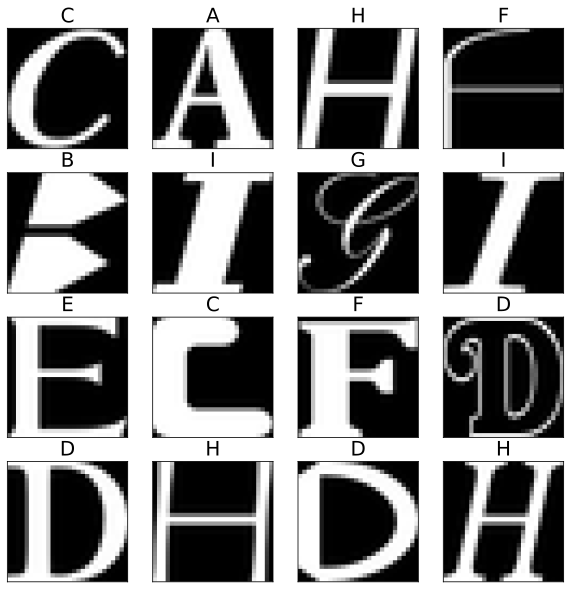

In [6]:
plot_letters(X_train, y_train, random_state=912)

I will also visualize accuracy graphs using BayesSearchCV, on my way to seek optimal ranges for parameters

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## How the training will be done

Here and below I will use the `skopt.BayesSearchCV` to search for hyperparameters

link - `https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html`

In [5]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # For plotting

## Naive Bayes

In [13]:
from sklearn.naive_bayes import GaussianNB

In [14]:
optNB = BayesSearchCV(
    estimator=GaussianNB(),
    search_spaces={
        'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
    },
    n_iter=100,
    cv=5
)

In [15]:
%%time
optNB.fit(X_train, y_train)
optNB.best_estimator_

/home/n2749/.local/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(1e-07)] before, using random point [1e-08]
  warnings.warn(
/home/n2749/.local/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(1e-06)] before, using random point [1e-09]
  warnings.warn(
/home/n2749/.local/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(1e-06)] before, using random point [1e-06]
  warnings.warn(
/home/n2749/.local/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(1e-09)] before, using random point [1e-09]
  warnings.warn(
/home/n2749/.local/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(1e-06)] before,

CPU times: user 17min 58s, sys: 23.4 s, total: 18min 22s
Wall time: 3min 18s


GaussianNB()

In [17]:
print(f'Train score {optNB.best_score_}')

Train score 0.8063083505500735


In [19]:
y_pred_NB = optNB.predict(X_test)
print(f'Test score {accuracy_score(y_test, y_pred_NB)}')

Test score 0.8053834650715659


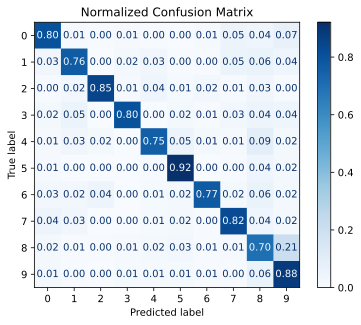

In [20]:
cm = confusion_matrix(y_test, y_pred_NB, normalize='true')

display_labels = np.unique(y_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues, values_format=".2f")

plt.title("Normalized Confusion Matrix")
plt.show()


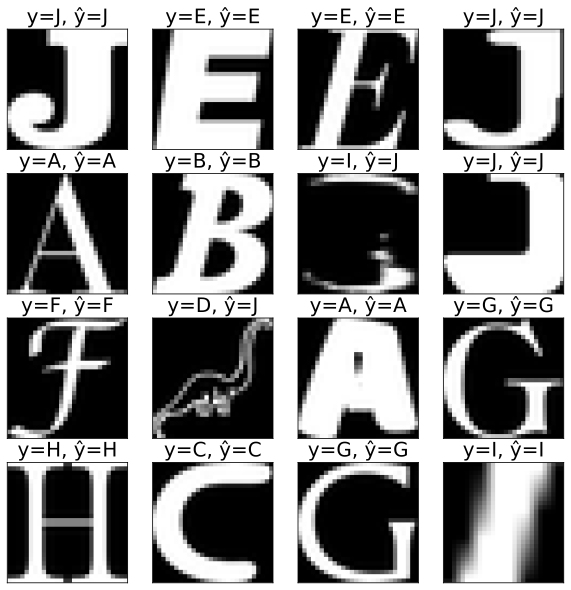

In [24]:
plot_letters(X=X_test, y_true=y_test, y_pred=y_pred_NB, random_state=3301)

## Decision tree

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

In [83]:

# Define the DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(random_state=3301)

# # Define hyperparameter search space
param_dist = {
    'max_depth': np.arange(15, 20),                    # the more the merrier
    'min_samples_split': np.arange(2, 5),            # less better
    'min_samples_leaf': np.arange(5, 10),             # around 5-10
    'criterion': ['gini', 'entropy'],
    'ccp_alpha': Real(1e-4, 1e-2)   # the less is better
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=3301)

optDT = BayesSearchCV(
    estimator=dt_clf,
    search_spaces=param_dist,
    n_iter=50,
    scoring='accuracy',
    cv=cv_strategy,
    random_state=3301,
    n_jobs=-1
)


In [84]:
%%time
optDT.fit(X_train, y_train)
print(optDT.best_score_)
print(optDT.best_params_)
print(optDT.best_estimator_)

0.8211918801897442
OrderedDict({'ccp_alpha': 9.830965189259327e-05, 'criterion': 'entropy', 'max_depth': 16, 'min_samples_leaf': 7, 'min_samples_split': 2})
DecisionTreeClassifier(ccp_alpha=9.830965189259327e-05, criterion='entropy',
                       max_depth=16, min_samples_leaf=7, random_state=42)
CPU times: user 6min 19s, sys: 1.42 s, total: 6min 20s
Wall time: 4min 14s


In [85]:
y_pred_DT = optDT.predict(X_test)
print(f'Test score {accuracy_score(y_test, y_pred_DT)}')
# 0.8340098269600513 OrderedDict({'ccp_alpha': 0.0005882617401385523, 'criterion': 'entropy', 'max_depth': 18, 'min_samples_leaf': 7, 'min_samples_split': 4})

Test score 0.8333689382610553


/tmp/ipykernel_7156/1439481170.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pairplot_data.rename(columns={


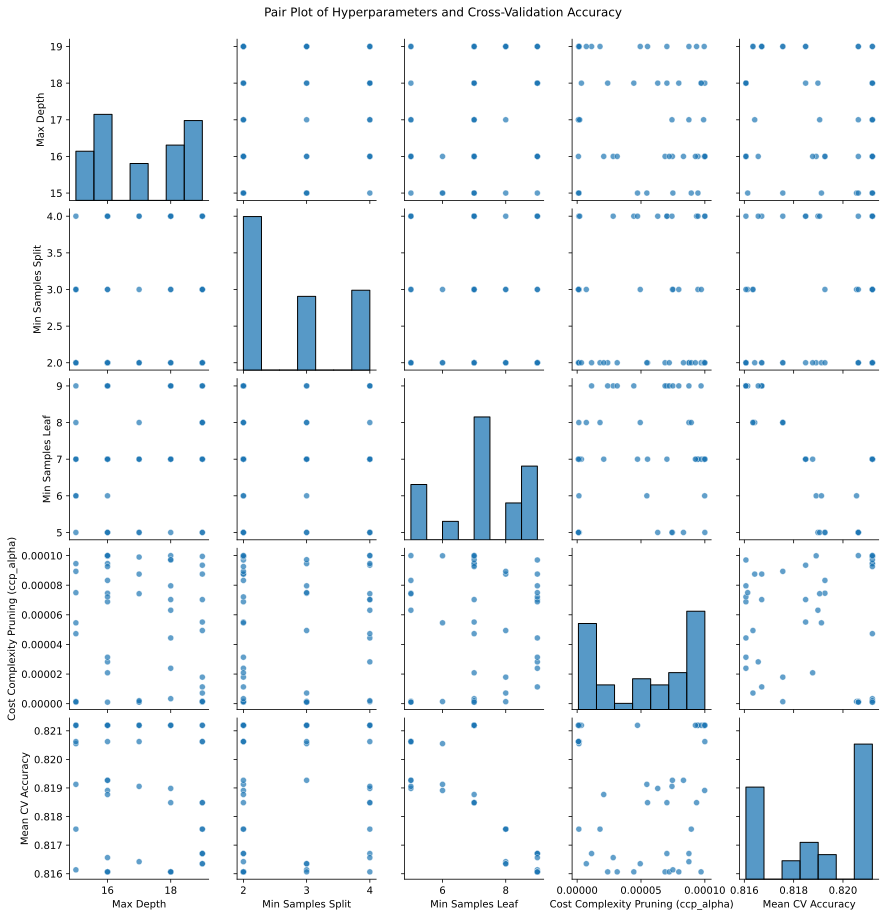

In [82]:
# Assuming optDT is the fitted BayesSearchCV instance
results_df = pd.DataFrame(optDT.cv_results_)

# Select the hyperparameters and accuracy score for visualization
columns_to_plot = [
    'param_max_depth',
    'param_min_samples_split', 
    'param_min_samples_leaf',
    'param_ccp_alpha',
    'mean_test_score'
]

# Filter results to only include relevant columns
pairplot_data = results_df[columns_to_plot]

# Rename columns for easier understanding in the pair plot
pairplot_data.rename(columns={
    'param_max_depth': 'Max Depth',
    'param_min_samples_split': 'Min Samples Split',
    'param_min_samples_leaf': 'Min Samples Leaf',
    'param_ccp_alpha': 'Cost Complexity Pruning (ccp_alpha)',
    'mean_test_score': 'Mean CV Accuracy'
}, inplace=True)

# Create a pair plot using Seaborn
sns.pairplot(pairplot_data, diag_kind='hist', markers='o', plot_kws={'alpha': 0.7})
plt.suptitle('Pair Plot of Hyperparameters and Cross-Validation Accuracy', y=1.02)
plt.show()


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [48]:
optRF = BayesSearchCV(
    DecisionTreeClassifier(random_state=3301),
    {
        'criterion': Categorical(['gini', 'entropy']),
        'splitter': Categorical(['best', 'random']),
        'max_depth': Integer(1, 50),
        'min_samples_split': Integer(2, 20),
        'min_samples_leaf': Integer(1, 10),
        'max_features': Categorical(['sqrt', 'log2', None]),
        'ccp_alpha': Real(0.0, 0.1)
    },
    n_iter=50,
    random_state=3301,
    cv=5,
    n_jobs=-1
)

In [49]:
%%time
optRF.fit(X_train, y_train)
optRF.best_estimator_

/home/n2749/knowledge/university/master/machine-learning/.venv/lib64/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


CPU times: user 9min 49s, sys: 2.53 s, total: 9min 52s
Wall time: 3min 4s


DecisionTreeClassifier(criterion='entropy', max_depth=43, splitter='random')

In [50]:
print(f'Train score {optRF.best_score_}')

Train score 0.8227568539868291


In [51]:
y_pred_RF = optRF.predict(X_test)
print(f'Test score {accuracy_score(y_test, y_pred_RF)}')

Test score 0.8344370860927153


## MLP

In [4]:
from sklearn.neural_network import MLPClassifier

In [5]:
optMLP = BayesSearchCV(
    MLPClassifier(random_state=3301),
    {
        'activation': Categorical(['relu', 'tanh', 'logistic']),
        'solver': Categorical(['adam', 'sgd']),
        'alpha': Real(1e-5, 1e-2, prior='log-uniform'),
        'learning_rate': Categorical(['constant', 'invscaling', 'adaptive']),
        'learning_rate_init': Real(1e-4, 1e-1, prior='log-uniform'),
        'max_iter': Integer(200, 1000)
    },
    n_iter=50,
    random_state=3301,
    cv=5,
    n_jobs=-1
)

In [10]:
%%time
optMLP.fit(X_train, y_train)
optMLP.best_estimator_

/home/n2749/knowledge/university/master/machine-learning/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/n2749/knowledge/university/master/machine-learning/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/n2749/knowledge/university/master/machine-learning/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/n2749/knowledge/university/master/machine-learning/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: 

CPU times: user 9min 10s, sys: 4.25 s, total: 9min 14s
Wall time: 29min 15s


MLPClassifier(alpha=0.002415690485342943, learning_rate_init=0.1, max_iter=882,
              random_state=3301, solver='sgd')

In [11]:
print(f'Train score {optMLP.best_score_}')

Train score 0.9168986742856446


In [12]:
y_pred_MLP = optMLP.predict(X_test)
print(f'Test score {accuracy_score(y_test, y_pred_MLP)}')

Test score 0.9139072847682119


## CNN

In [90]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 5
batch_size = 64
learning_rate = 0.001

# Data transformations
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=data_transform)

# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# CNN model definition
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate model, define loss function and optimizer
model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}')
            running_loss = 0.0

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')


ModuleNotFoundError: No module named 'tensorflow'

In [86]:
# Define a function to create the CNN model
def create_cnn_model(filters=32, kernel_size=3, pool_size=2, dropout_rate=0.5, dense_units=128):
    model = Sequential()
    model.add(Conv2D(filters, (kernel_size, kernel_size), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Wrap the Keras model so it can be used by scikit-learn
model = KerasClassifier(build_fn=create_cnn_model, epochs=10, batch_size=128, verbose=0)

# Define hyperparameter search space
param_space = {
    'filters': [16, 32, 64],
    'kernel_size': [3, 5],
    'pool_size': [2, 3],
    'dropout_rate': (0.1, 0.5),
    'dense_units': [64, 128, 256],
    'batch_size': [32, 64, 128],
    'epochs': [10, 20]
}

# Set up cross-validation strategy
cv_strategy = KFold(n_splits=3, shuffle=True, random_state=42)

# Set up BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=model,
    search_spaces=param_space,
    n_iter=20,  # Number of iterations for Bayesian optimization
    cv=cv_strategy,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

# Fit the model to the training data
bayes_search.fit(X_train, y_train)

# Output the best parameters and score
print("Best Parameters:", bayes_search.best_params_)
print("Best Cross-Validation Score:", bayes_search.best_score_)

# Evaluate the best model on the test set
best_model = bayes_search.best_estimator_.model
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print("Test Set Accuracy:", test_acc)


NameError: name 'KerasClassifier' is not defined

## Plot results